<a href="https://colab.research.google.com/github/srpantano/LLM/blob/main/grafo_3_nos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vamos construir um grafo simples com 3 nós e uma aresta condicional."


![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Estado

Primeiro, defina o [Estado](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) do grafo.

O esquema do Estado serve como o esquema de entrada para todos os Nós e Arestas no grafo.

Vamos usar a classe `TypedDict` do módulo `typing` do Python como nosso esquema, que fornece dicas de tipo para as chaves.

In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str


## Nós

[Nós](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) são apenas funções Python.

O primeiro argumento posicional é o estado, conforme definido acima.

Como o estado é um `TypedDict` com o esquema definido acima, cada nó pode acessar a chave `graph_state` com `state['graph_state']`.

Cada nó retorna um novo valor para a chave de estado `graph_state`.

Por padrão, o novo valor retornado por cada nó [substituirá](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) o valor do estado anterior.

In [3]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" Eu estou "}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" cansado!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" descansado!"}

## Arestas

[Arestas](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) conectam os nós.

Arestas Normais são usadas quando você quer *sempre* ir de, por exemplo, `node_1` para `node_2`.

[Arestas Condicionais](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) são usadas quando você quer rotear *opcionalmente* entre nós.

Arestas condicionais são implementadas como funções que retornam o próximo nó a ser visitado com base em alguma lógica.

In [4]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Frequentemente, usaremos o estado para decidir o próximo nó a ser visitado
    user_input = state['graph_state']

    # Aqui, vamos fazer uma divisão de 50/50 entre os nós 2, 3
    if random.random() < 0.5:

        # 50% das vezes, retornamos o nó 2
        return "node_2"

    # 50% das vezes, retornamos o nó 3
    return "node_3"

Agora, vamos construir o grafo a partir dos nossos [componentes](
https://langchain-ai.github.io/langgraph/concepts/low_level/) definidos acima.

A [classe StateGraph](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) é a classe de grafo que podemos usar.

Primeiro, inicializamos um StateGraph com a classe `State` que definimos acima.

Em seguida, adicionamos nossos nós e arestas.

Usamos o [Nó `START`, um nó especial](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) que envia a entrada do usuário para o grafo, para indicar onde começar nosso grafo.

O [Nó `END`](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) é um nó especial que representa um nó terminal.

Por fim, [compilamos nosso grafo](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) para realizar algumas verificações básicas na estrutura do grafo.

Podemos visualizar o grafo como um [diagrama Mermaid](https://github.com/mermaid-js/mermaid).

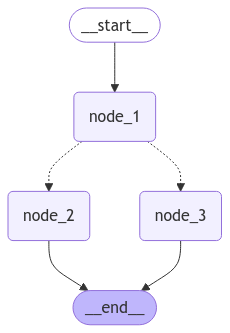

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Construindo o grafo
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logica
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)


# Compila o grafo
graph = builder.compile()

# Visualiza o grafo
display(Image(graph.get_graph().draw_mermaid_png()))

## Invocação do Grafo

O grafo compilado implementa o protocolo [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/).

Isso fornece uma maneira padrão de executar componentes LangChain.

`invoke` é um dos métodos padrão nesta interface.

A entrada é um dicionário `{"graph_state": "Olá, aqui é o Sergio."}`, que define o valor inicial para o nosso dicionário de estado do grafo.

Quando `invoke` é chamado, o grafo inicia a execução a partir do nó `START`.

Ele progride através dos nós definidos (`node_1`, `node_2`, `node_3`) em ordem.

A aresta condicional atravessará do nó `1` para o nó `2` ou `3` usando uma regra de decisão 50/50.

Cada função de nó recebe o estado atual e retorna um novo valor, que substitui o estado do grafo.

A execução continua até atingir o nó `END`.

In [7]:
graph.invoke({"graph_state" : "Ola, sou eu, Sergio."})

---Node 1---
---Node 3---


{'graph_state': 'Ola, sou eu, Sergio. Eu estou  descansado!'}

`invoke` executa o grafo inteiro de forma síncrona.

Isso espera que cada etapa seja concluída antes de passar para a próxima.

Ele retorna o estado final do grafo após todos os nós terem sido executados.

Neste caso, ele retorna o estado após `node_3` ter sido concluído:

```
{'graph_state': 'Ola, sou eu, Sergio. Eu estou  cansado!'}
```